In [6]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
import statsmodels as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from pykalman import KalmanFilter

In [8]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df_content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df_content['Month'] = pd.to_datetime(df_content['Month'],
                                     infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')

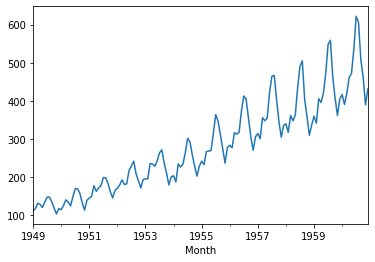

In [9]:
y.plot()

In [10]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend != 0) + (n_dim_series != 0)
    if n_dim_series > 0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend

    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2

    # トレンドモデルのブロック行列の構築
    G[0, 0] = 1
    H[0, 0] = 1
    if n_dim_trend == 1:
        F[0, 0] = 1
    elif n_dim_trend == 2:
        F[0, 0] = 2
        F[0, 1] = -1
        F[1, 0] = 1
    elif n_dim_trend == 3:
        F[0, 0] = 3
        F[0, 1] = -3
        F[0, 2] = 1
        F[1, 0] = 1
        F[2, 1] = 1

    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series > 0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series - 1):
            F[start_elem, start_elem + i] = -1
        for i in range(n_dim_series - 2):
            F[start_elem + i + 1, start_elem + i] = 1

    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)

    return n_dim_state, F, H, Q

In [11]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs, n_dim_series)

In [12]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [13]:
# 前半120時点を学習データに121時点以降のデータを検証用に使用
n_train = 120
train, test = y.values[:n_train], y.values[n_train:]

In [14]:
# フィルタ＋平滑化
smoothed_state_means, smoothed_state_covs = kf.smooth(train)
pred_o_smoothed = smoothed_state_means.dot(H.T)

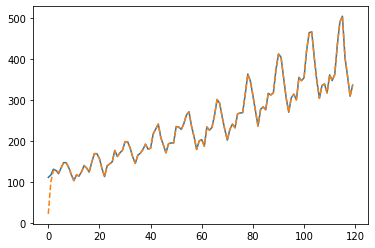

In [15]:
plt.plot(train, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")

In [16]:
kf.observation_matrices

array([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

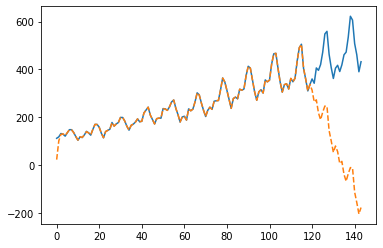

In [17]:
plt.plot(y.values, label="observation")

pred_y = np.empty(len(test))
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test)):
    current_state, current_cov = kf.filter_update(current_state,
                                                  current_cov,
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)

plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]),
         '--',
         label="forecast")

## EMアルゴリズムを用いたハイパーパラメタ最適化

In [18]:
# 繰り返し回数は10回
# ハイパーパラメタ更新の対象はF, H, Q, R
emed_kf = kf.em(train, n_iter=10, em_vars='all')

In [20]:
emed_kf.observation_matrices

array([[0.76674407, 0.23450638, 1.93042899, 0.29585304, 0.92924187,
        0.30481168, 0.89623253, 0.37839823, 0.9966391 , 0.29329334,
        0.96824822, 0.2760503 , 1.14262332]])

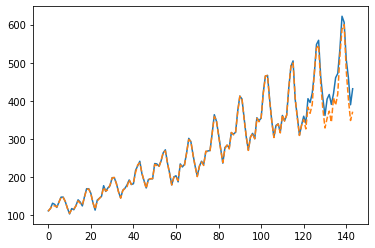

In [21]:
# ハイパーパラメタF, H, Q, R更新後の平滑化系列
em_smoothed_state_means, em_smoothed_state_covs = emed_kf.smooth(train)
em_pred_o_smoothed = np.dot(em_smoothed_state_means, emed_kf.observation_matrices.T)
plt.plot(y.values, label="observation")

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

pred_y = np.empty(len(test))
for i in range(len(test)):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)

plt.plot(np.hstack([em_pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")

In [23]:
train.shape

(120,)

In [22]:
em_smoothed_state_means.shape

(120, 13)

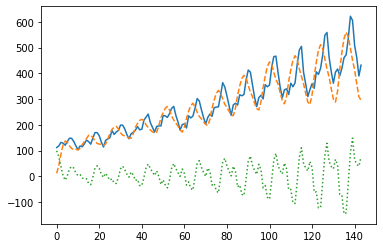

In [24]:
# 階差
diff = 2

# トレンド成分
# トレンド成分では階差の次数分の状態が対象
t_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, :diff], 
                              emed_kf.observation_matrices[:, :diff].T)
# 季節成分
# 季節成分は状態ベクトルにおいてトレンド成分以降の要素が対象
s_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, diff:], 
                              emed_kf.observation_matrices[:, diff:].T)

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

# トレンド成分と季節成分の長期予測値を格納するベクトルを用意
t_pred_y = np.empty(len(test))
s_pred_y = np.empty(len(test))
# トレンド成分および季節成分の長期予測
for i in range(len(test)):
    current_state, current_cov = emed_kf.filter_update(current_state, 
                                                       current_cov, 
                                                       observation=None)
    t_pred_y[i] = \
        emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = \
        emed_kf.observation_matrices[:, diff:].dot(current_state[diff:])

plt.plot(y.values, label="observation")
plt.plot(np.hstack([t_em_pred_o_smoothed.flatten(), t_pred_y]),
         '--', label="trend")
plt.plot(np.hstack([s_em_pred_o_smoothed.flatten(), s_pred_y]),
         ':', label="seasonal")

# トレンド成分＋季節成分の表示をしたい場合は以下のコメントアウトを外す
# plt.plot(
#     np.hstack([
#         s_em_pred_o_smoothed.flatten()+t_em_pred_o_smoothed.flatten(),
#         s_pred_y+t_pred_y]),
#     '+-', label="forecast")

In [15]:
emed_kf.observation_matrices.dot(em_smoothed_state_covs).shape

(1, 120, 13)

In [27]:
em_smoothed_state_covs.transpose(1,0,2).shape

(13, 120, 13)

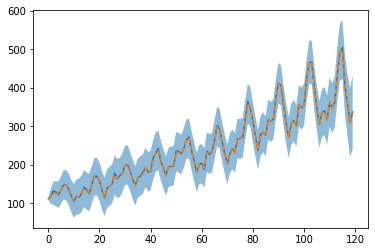

In [25]:
from scipy.stats import norm

# n_trainは訓練時点数
n_train = len(em_smoothed_state_covs)

# y_tの予測分布の分散
pred_cov = emed_kf.observation_matrices.dot(
    np.abs(em_smoothed_state_covs)).transpose(1,0,2).dot(emed_kf.observation_matrices.T)
# y_tの予測分布の平均
pred_mean = em_smoothed_state_means.dot(emed_kf.observation_matrices.T)

# 訓練データにおける推定値の95%信用区間の上下限
lower, upper = norm.interval(0.95, pred_mean.flatten(), scale=np.sqrt(pred_cov.flatten()))

plt.plot(train, label="observation")
plt.plot(em_pred_o_smoothed, '--', label="predict")
plt.fill_between(range(len(train)), upper,lower, alpha=0.5, label="credible interval")

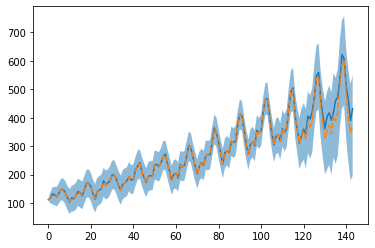

In [28]:
# 階差
diff = n_dim_trend
se = n_dim_trend + n_dim_series - 1
# トレンド成分
t_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, :diff], emed_kf.observation_matrices[:, :diff].T)
# 季節成分
s_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, diff:se], emed_kf.observation_matrices[:, diff:se].T)

current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

# 訓練データ数
n_test = len(test)
# 長期予測系列を保存するベクトル
# トレンド成分
t_pred_y = np.empty(n_test)
# 季節成分
s_pred_y = np.empty(n_test)
# 95%信用区間の下限
inf_lower = np.empty(n_test)
# 95%信用区間の上限
inf_upper = np.empty(n_test)

# トレンド成分および季節成分の長期予測
for i in range(len(test)):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    t_pred_y[i] = emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = emed_kf.observation_matrices[:, diff:se].dot(current_state[diff:se])

    # y_tの予測分布の分散
    pred_cov = emed_kf.observation_matrices.dot(np.abs(current_cov)).dot(emed_kf.observation_matrices.T)
    # y_tの予測分布の平均
    pred_mean = current_state.dot(emed_kf.observation_matrices.T)
    inf_lower[i], inf_upper[i] = norm.interval(0.95, pred_mean, scale=np.sqrt(pred_cov))
    
plt.plot(y.values, label="observation")
plt.plot(np.hstack([em_pred_o_smoothed.flatten(), t_pred_y+s_pred_y]), '--', label="forecast")
all_lower = np.hstack([lower, inf_lower])
all_upper = np.hstack([upper, inf_upper])
plt.fill_between(range(len(y.values)), all_upper, all_lower, alpha=0.5, label="credible interval")